<a href="https://colab.research.google.com/github/RGologorsky/fastproj/blob/master/Image_Segmentation_Hair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Segment pixels representing hair

# Imports

In [0]:
%matplotlib inline

In [0]:
%%capture
!pip install fastai2

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [401]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# utils

# print n items in list, w each item on newline
def pprint_l(l, n=4): print(f"len {len(l)}:", *l[:n], sep="\n")

# given path x/y/z, returns folder name z
def get_folder_name(x): return re.search("([^\/])*$", str(x)).group(0)

# given input string "aaa_bbb_ccc", returns up to first underscore "aaa"
def get_stem(s): return re.search("^([^_])*", s).group(0)

# returns folder stem
def get_folder_stem(x): return get_stem(get_folder_name(x))

## Load project data (unzip if needed)

In [0]:
proj = "segmentation"
base_path = Path("drive/My Drive/fastai_proj")

In [404]:
proj_path = base_path/proj
pprint_l(proj_path.ls())

len 2:
drive/My Drive/fastai_proj/segmentation/face_segment_data_sampleset.zip
drive/My Drive/fastai_proj/segmentation/data


In [0]:
data_src = proj_path/"face_segment_data_sampleset.zip"
data_dest = proj_path/"data"

In [0]:
# !unzip -qq "$data_src" -d "$data_dest"

## Define training set (x), labelled set (y), and validation set (subset of training set).

In [407]:
data_dirs = [get_folder_name(x) for x in data_dest.ls()]
data_dirs

['malekumar_env01',
 'maleshawn_env01',
 'male20_blackhair_browneyes_env06',
 'male22_blackhair_browneyes_env04',
 'multiperson_env01',
 'maleandrew2_env01',
 'malecarlos_env01',
 'real',
 'sampleset.xml',
 'femalefelice_env04',
 'femalejanna_blondhair_smile_env07',
 'femalemei_blackhair_browneyes_env10',
 'femalemira_blackhair_env01',
 'femalemyriam_env01',
 'femalesophia_brownhair_smile_env05',
 'labels',
 'models']

In [0]:
path_lbls = data_dest/"labels"

In [0]:
valid_dirs = ['malekumar_env01', 'male22_blackhair_browneyes_env04', 'femalesophia_brownhair_smile_env05']
training_dirs = [x for x in data_dirs if x != "labels"]

In [0]:
valid_names = get_image_files(data_dest, folders=valid_dirs)
train_names = get_image_files(data_dest, folders=training_dirs)
lbl_names = get_image_files(path_lbls)


In [411]:
percent_valid = len(valid_names)/len(lbl_names)
print(f"percent valid = {round(percent_valid, 3)}\n")
pprint_l(valid_names,2)
pprint_l(train_names,2)
pprint_l(lbl_names,2)

percent valid = 0.188

len 75:
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0003.png
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0024.png
len 400:
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0003.png
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0024.png
len 400:
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0002.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0062.png


## Define y: training image fname -> labelled image fname

In [0]:
get_y_fn = lambda x: path_lbls/get_folder_stem(x.parents[0])/f"{x.stem}.png"

In [207]:
pp_list([train_names[0], get_y_fn(train_names[0])])

len 2:
drive/My Drive/fastai_proj/segmentation/data/maleshawn_env01/headrende0000.png
drive/My Drive/fastai_proj/segmentation/data/labels/maleshawn/headrende0000.png


## View image/label mask

In [0]:
idx = -1
fn = data_dest/"maleandrew2_env01/headrende0240.png"

In [0]:
# training image
img_fn = train_names[idx] if idx != -1 else fn
img = PILImage.create(img_fn)
#img.show()

In [0]:
# labeled image
img_lbl_fn = get_y_fn(img_fn)
img_lbl = PILImage.create(img_lbl_fn)
# img_lbl.show()

In [0]:
# masked image
mask = PILMask.create(img_lbl_fn)
# mask.show()

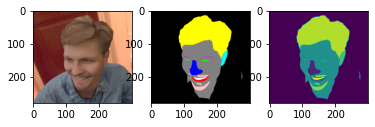

In [418]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img)
ax2.imshow(img_lbl)
ax3.imshow(mask)
plt.show()

In [419]:
img_lbl_t = tensor(img_lbl)
img_lbl_t.shape #img_lbl_t

torch.Size([280, 300, 3])

In [420]:
mask_t = tensor(mask)
mask_t.shape #mask_t

torch.Size([280, 300])

In [421]:
np.array(mask.size)

array([300, 280])

In [422]:
idx1,idx2 = 200,150
img_lbl_t[idx1,idx2], mask_t[idx1,idx2]

(tensor([255, 192, 192], dtype=torch.uint8), tensor(211, dtype=torch.uint8))

In [423]:
img_lbl_t.unique(),mask_t.unique()

(tensor([  0, 128, 192, 255], dtype=torch.uint8),
 tensor([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=torch.uint8))

## Codes found

In [0]:
# px wo code is given code "void"
void_code = "void"

In [0]:
val2code = {
    0: "not_face",
    29: "nose",
    76: "mouth",
    105: "eyebrow",
    128: "skin",
    150: "eye",
    179: "ear",
    211: "facial_hair",
    226: "hair",
    255: "teeth",
}

In [447]:
code2val = {code:val for val,code in val2code.items()}
code2val

{'ear': 179,
 'eye': 150,
 'eyebrow': 105,
 'facial_hair': 211,
 'hair': 226,
 'mouth': 76,
 'nose': 29,
 'not_face': 0,
 'skin': 128,
 'teeth': 255}

In [448]:
codes = [str(c) for c in val2code.values()]
codes

['not_face',
 'nose',
 'mouth',
 'eyebrow',
 'skin',
 'eye',
 'ear',
 'facial_hair',
 'hair',
 'teeth']

### Check if any px vals missing in val2code

In [0]:
missing_codes = {}
def check_missing():
  for f in lbl_names:
    mask = PILMask.create(get_y_fn(f))
    vals = np.unique(mask)
    for v in vals:
      if v not in px_vals:
        missing_codes[v] = f

In [0]:
fn2missing = {}
for (px,fn) in missing_codes.items():
  fn2missing.setdefault(fn, []).append(px)

In [170]:
# check_missing_codes()
len(fn2missing)

0

#### Check pixels a code corresponds to

In [140]:
lbl_fn = list(fn2missing.keys())[1]
lbl_fn

Path('drive/My Drive/fastai_proj/segmentation/data/labels/real/10587826073_6663f5b654_o_scaled_scaled.png')

In [0]:
mask = PILMask.create(lbl_fn)

In [142]:
unique_vals = np.unique(mask)
unique_vals

array([  0,  29,  76,  77,  79,  80,  81,  99, 103, 105, 110, 114, 116,
       128, 135, 150, 157, 165, 169, 170, 172, 179, 186, 191, 195, 201,
       202, 204, 207, 214, 217, 221, 225, 226, 232, 241, 252, 253, 254,
       255], dtype=uint8)

In [143]:
missing_vals = fn2missing[lbl_fn]
missing_vals

[116,
 202,
 214,
 217,
 221,
 225,
 77,
 79,
 80,
 81,
 99,
 103,
 110,
 114,
 135,
 157,
 165,
 169,
 170,
 172,
 186,
 191,
 195,
 201,
 204,
 207,
 232,
 241,
 252,
 253,
 254]

In [0]:
orig_mask = mask
mask_arr = np.array(orig_mask)

In [0]:
# mask_arr.shape, img_arr.shape
unique, counts = np.unique(orig_mask, return_counts=True)
d = dict(zip(unique, counts))

In [0]:
non_errors = []
for val in missing_vals:
  if d[val] > 1:
    non_errors.append(val)

In [147]:
len(non_errors)

4

In [148]:
non_errors

[202, 225, 195, 254]

In [0]:
val = 254

In [163]:
d[val]

3

In [0]:
mask_arr[mask_arr != val] = 0
new_mask = Image.fromarray(mask_arr)
#new_mask


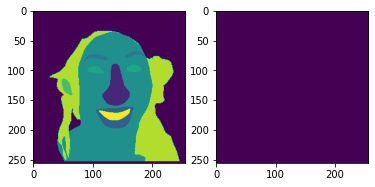

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(orig_mask)
ax2.imshow(new_mask)
plt.show()

In [0]:
## Replace mask codes with new codes

## Get y: make labelled mask correspond with codes

In [0]:
def get_mask(fn, classes, void_code=void_code):
  "Grab a mask from a `filename` and adjust the pixels based on `code2val`"
  y = np.array(PILMask.create(get_y_fn(fn)))

  class2id = {c:i for i,c in enumerate(classes)}
  class2id[void_code] = len(classes)
  vals = [code2val[c] for c in classes]
  
  void_mask = np.isin(y, vals, invert=True)
  for c in classes: y[y==code2val[c]] = class2id[c]
  y[void_mask] = class2id["void"]
  
  return PILMask.create(y)

In [0]:
# set classes to classify (subset of all codes)
classes = ['facial_hair', 'hair', 'eyebrow']

In [0]:
get_y = lambda fn: get_mask(fn, classes)

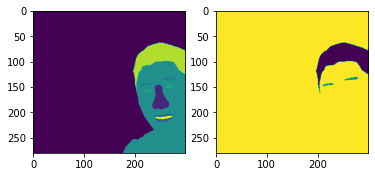

In [492]:
# test
fn = train_names[28]
orig_mask = PILMask.create(get_y_fn(fn))
new_mask = get_y(fn)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(orig_mask)
ax2.imshow(new_mask)

In [0]:
def get_sizes(fnames):
  sizes = {}
  for fn in fnames:
    m = PILMask.create(get_y_fn(fn))
    sz = mask.shape
    if sz in sizes: sizes[sz] += 1
    else: sizes[sz] = 1
  return sizes

def get_img_sizes(imgs):
  sizes = {}
  for m in imgs:
    sz = m.shape
    if sz in sizes: sizes[sz] += 1
    else: sizes[sz] = 1
  return sizes


In [0]:
lbl_sizes = get_sizes(lbl_names)
train_sizes = get_sizes(train_names)
valid_sizes = get_sizes(valid_names)

In [522]:
lbl_sizes, train_sizes, valid_sizes

({(280, 300): 400}, {(280, 300): 400}, {(280, 300): 75})

In [0]:
orig_size = orig_mask.shape
orig_bs = 16

In [511]:
orig_mask.shape

(280, 300)

## Dataloaders

In [0]:
get_items_fn = lambda src_path: train_names

In [0]:
def get_dls(bs, size):
  db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items = get_items_fn,
    get_y = get_y,
    splitter= FuncSplitter(lambda o: o in valid_names),
    item_tfms = Resize(460),
    batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]
  )
  return db.dataloaders(source = "data_dest", bs=bs)

In [542]:
half_size = tuple(x//2 for x in orig_size)
half_bs = orig_bs//2
orig_size, half_size, orig_bs, half_bs

((280, 300), (140, 150), 16, 8)

In [0]:
dls = get_dls(orig_bs, half_size)

In [544]:
dls.valid_ds

(#75) [(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280),(PILImage mode=RGB size=300x280, PILMask mode=L size=300x280)...]

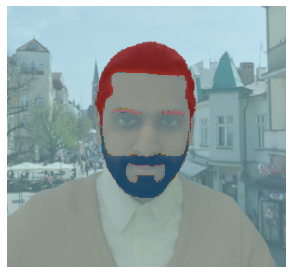

In [545]:
show_at(dls.valid_ds, 0)

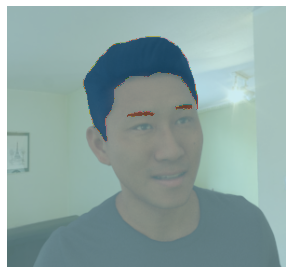

In [546]:
show_at(dls.train_ds, 0)

In [0]:
b = dls.train.one_batch()

### Check sizes in dls

In [0]:
dls_sizes = get_img_sizes([x[1] for x in dls.train_ds])
dls_sizes

In [538]:
dls_sizes

{(254, 256): 1,
 (256, 256): 57,
 (258, 256): 1,
 (259, 256): 1,
 (261, 256): 1,
 (280, 300): 250,
 (304, 304): 13,
 (343, 256): 1}

In [539]:
dls_sizes0 = get_img_sizes([x[0] for x in dls.train_ds])
dls_sizes0

{(254, 256): 1,
 (256, 256): 57,
 (258, 256): 1,
 (259, 256): 1,
 (261, 256): 1,
 (280, 300): 250,
 (304, 304): 13,
 (369, 256): 1}

In [535]:
dls.train_ds[0][1].shape

(280, 300)

### Show batch

In [0]:
b = dls.train.decode(b)

In [549]:
b[0].shape, b[1].shape

(torch.Size([16, 3, 140, 150]), torch.Size([16, 140, 150]))

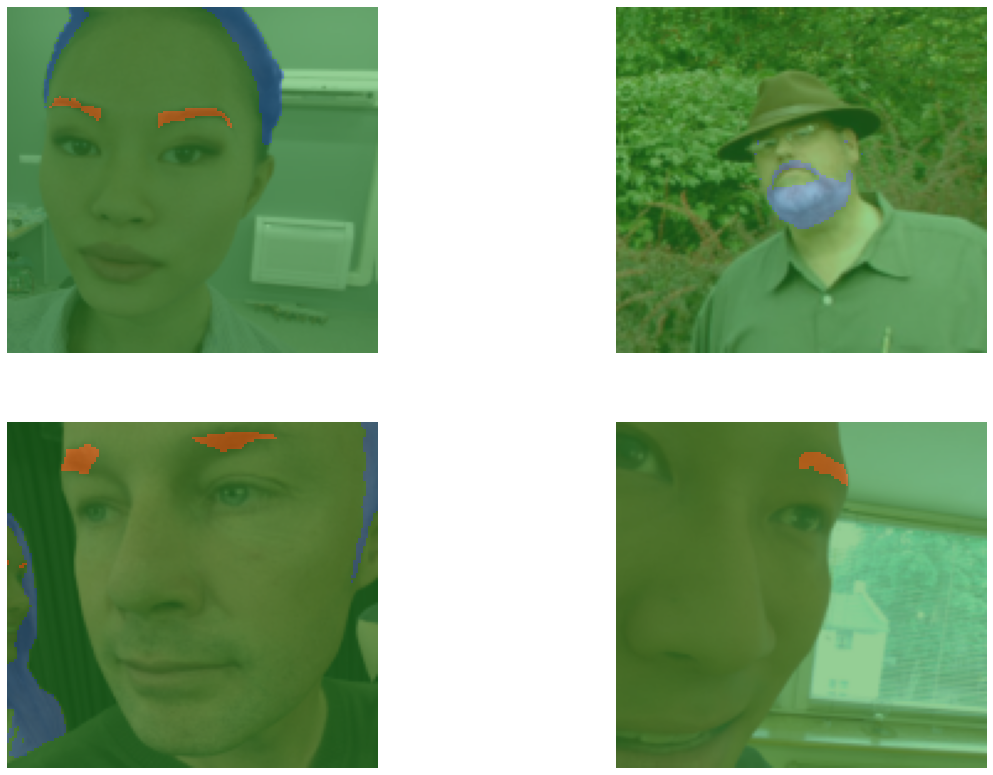

In [550]:
dls.show_batch(max_n=4, figsize=(20,14))

## Model

In [0]:
def acc_non_void(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# def acc_hair(input, target):
#   target = target.squeeze(1)
#   mask = np.isin(target,hair_idxs)
#   return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=[acc_non_void]

In [0]:
wd=1e-2

In [0]:
dls.vocab = codes

In [0]:
# learn = unet_learner(dls, resnet34, metrics=metrics).to_fp16() # add model_dir="foodir"
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_non_void, config=config,
                     opt_func=opt).to_fp16()

(0.001096478197723627, 0.0003981071640737355)

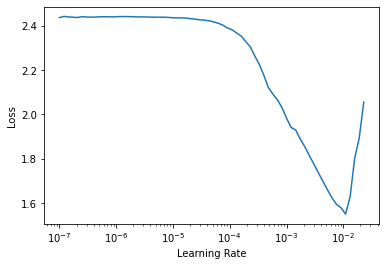

In [558]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [0]:
lr = 1e-3

In [562]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_non_void,time
0,0.808055,0.447953,0.892606,00:09
1,0.486081,0.247602,0.944201,00:08
2,0.349532,0.195758,0.948975,00:08
3,0.277806,0.189419,0.947714,00:08
4,0.237469,0.238051,0.939774,00:08
5,0.200387,0.164819,0.954736,00:08
6,0.173574,0.201072,0.954714,00:08
7,0.152239,0.178482,0.953292,00:08
8,0.137579,0.186176,0.956236,00:08
9,0.122574,0.177835,0.957879,00:08


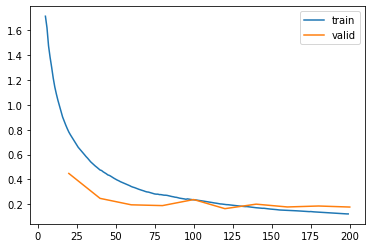

In [564]:
learn.recorder.plot_loss()

In [0]:
# learn.fit_one_cycle(10,slice(lr),pct_start=0.9,wd=wd)
learn.save('stage-1-sm')


In [0]:
learn.load('stage-1-sm');

## unfreeze

In [0]:
lrs = slice(lr/400, lr/4)

In [567]:
learn.unfreeze()
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_non_void,time
0,0.096373,0.198082,0.953500,00:08
1,0.093713,0.187838,0.957767,00:08
2,0.090893,0.162934,0.959607,00:09
3,0.089143,0.211928,0.959543,00:09
4,0.088803,0.163987,0.961142,00:09
5,0.085356,0.161598,0.961059,00:09
6,0.087018,0.164905,0.957952,00:09
7,0.083801,0.152314,0.961185,00:09
8,0.079379,0.195121,0.961376,00:09
9,0.078194,0.148619,0.963538,00:08


In [0]:
learn.save('model-1-sm')

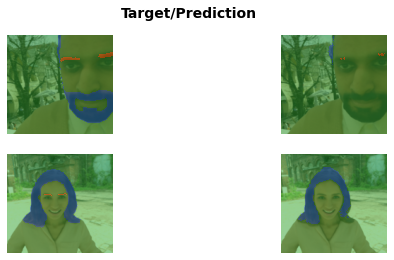

In [569]:
learn.show_results(max_n=4, figsize=(9,4))

In [570]:
del learn
import gc
gc.collect()

19793

In [0]:
dls = get_dls(orig_bs, orig_size)

In [0]:
dls.vocab = classes

In [0]:
# learn = unet_learner(dls, resnet34, metrics=metrics).to_fp16() # add model_dir="foodir"
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_non_void, config=config,
                     opt_func=opt).to_fp16()

In [585]:
learn.load("model-1-sm")

In [586]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

RuntimeError: ignored

In [384]:
lr_min, lr_steep

(3.981071586167673e-07, 1.737800812406931e-05)

In [387]:
lr = 3e-5
learn.fit_one_cycle(12, slice(lr/400,lr/4),pct_start=0.8,wd=wd)

epoch,train_loss,valid_loss,acc_hair,acc_non_void,time
0,0.268872,0.327772,nan,0.886362,00:29
1,0.266570,0.322345,nan,0.894002,00:29
2,0.261566,0.311978,nan,0.895471,00:29
3,0.264143,0.315752,nan,0.895811,00:29
4,0.255549,0.314701,nan,0.897361,00:29
5,0.256167,0.318969,nan,0.889945,00:29
6,0.256306,0.334395,nan,0.883928,00:29
7,0.252167,0.303931,nan,0.896596,00:29
8,0.250364,0.295724,nan,0.903060,00:29
9,0.239360,0.287429,nan,0.904591,00:29


In [0]:
learn.save("stage-2-904")

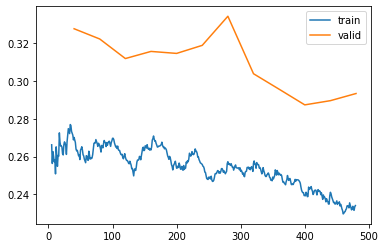

In [389]:
learn.recorder.plot_loss()

#### Diff suffixes in training/label (.jpg/.png)

In [0]:
def get_suffix_cnts(lst):
  d = {}
  for p in lst:
    suffix = p.suffix
    if suffix in d: d[suffix] += 1
    else: d[suffix]= 0
  return d

In [0]:
lbl_suffixes = get_suffix_cnts(lbl_names)
train_suffixes = get_suffix_cnts(train_names)
valid_suffixes = get_suffix_cnts(valid_names)

In [196]:
lbl_suffixes

{'.png': 399}

In [199]:
train_suffixes

{'.jpg': 50, '.png': 273}

In [201]:
valid_suffixes

{'.png': 74}

In [203]:
50 + 74 + 273

397

In [190]:
t = "drive/My Drive/fastai_proj/segmentation/data/labels/real/11856514663_0f0780b5d4_o_scaled_scaled.jpg'"
Path(t) in lbl_names

False